 # [傅里叶微分 (Fourier Differentiation)](<傅里叶微分（Fourier Differentiation）原理详解.md>)



 本教程演示了基于傅里叶方法的周期函数微分计算。傅里叶微分的核心优势在于：



 - 以谱精度（spectral accuracy）计算函数的导数（精度远高于有限差分法）

 - 可用于实现物理信息损失函数（physics-informed loss functions）



 `FourierDiff` 类提供了高效的谱微分实现，支持1D/2D/3D周期函数在周期域上的微分计算。



 ## 导入依赖库

 首先导入 `neuralop` 库及其他必要的依赖包

In [32]:
# 导入PyTorch（深度学习框架，核心计算库）
import torch
# 导入NumPy（数值计算库）
import numpy as np
# 导入Matplotlib（绘图库）
import matplotlib.pyplot as plt
# 从neuralop库导入傅里叶微分核心类
from neuralop.losses.differentiation import FourierDiff

# 设置计算设备：优先使用GPU（CUDA），否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


 ## 构建1D周期函数示例

 这里选择sin(x)和cos(x)作为示例，它们在区间[0, 2π]上具有周期性

In [33]:
# 定义周期长度为2π（符合三角函数的自然周期）
L = 2 * torch.pi
# 生成x轴采样点：在[0, 2π]区间生成101个点，然后去掉最后一个点（避免0和2π重复）
x = torch.linspace(0, L, 101)[:-1]
# 构建待微分的函数集合：堆叠sin(x)和cos(x)，dim=0表示新增维度索引是0（shape: [2, 100]）
f = torch.stack([torch.sin(x), torch.cos(x)], dim=0)
# 转换为NumPy数组（用于Matplotlib绘图）
x_np = x.cpu().numpy()


 ## 对信号进行傅里叶微分

 使用FourierDiff类计算函数的各阶导数

In [34]:
# 初始化1D傅里叶微分器：
# - dim=1：指定1维微分
# - L=L：指定周期长度
# - use_fc=False：不使用傅里叶延拓（因为函数本身是周期的）
fd1d = FourierDiff(dim=1, L=L, use_fc=False)
# 计算多阶导数：参数[1,2,3]表示计算1阶、2阶、3阶导数
derivatives = fd1d.compute_multiple_derivatives(f, [1, 2, 3])
# 解包导数结果
dfdx, df2dx2, df3dx3 = derivatives


 ## 绘制sin(x)的微分结果

 对比傅里叶微分计算结果与解析解（理论值）

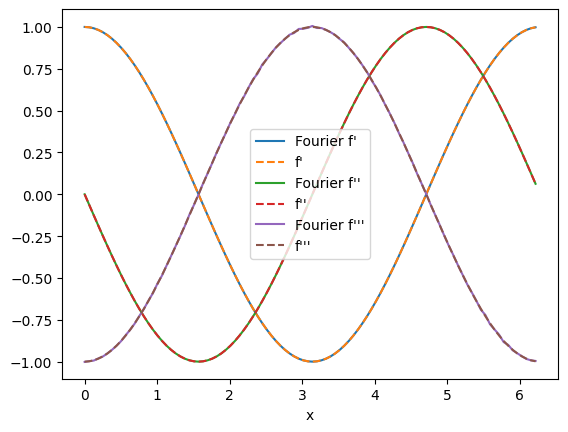

In [35]:
# 创建绘图窗口
plt.figure()
# 绘制1阶导数（傅里叶计算结果）
plt.plot(x_np, dfdx[0].squeeze().cpu().numpy(), label="Fourier f'")
# 绘制1阶导数解析解（cos(x)），虚线表示
plt.plot(x_np, np.cos(x_np), "--", label="f'")
# 绘制2阶导数（傅里叶计算结果）
plt.plot(x_np, df2dx2[0].squeeze().cpu().numpy(), label="Fourier f''")
# 绘制2阶导数解析解（-sin(x)）
plt.plot(x_np, -np.sin(x_np), "--", label="f''")
# 绘制3阶导数（傅里叶计算结果）
plt.plot(x_np, df3dx3[0].squeeze().cpu().numpy(), label="Fourier f'''")
# 绘制3阶导数解析解（-cos(x)）
plt.plot(x_np, -np.cos(x_np), "--", label="f'''")
# 设置x轴标签
plt.xlabel("x")
# 显示图例
plt.legend()
# 显示图像
plt.show()


 ## 绘制cos(x)的微分结果

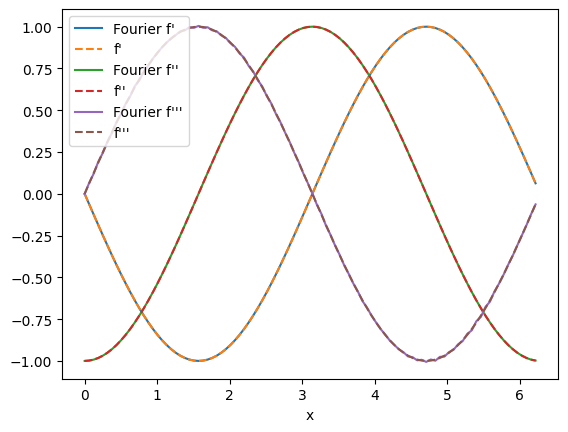

In [36]:
plt.figure()
# 绘制1阶导数（傅里叶计算结果）
plt.plot(x_np, dfdx[1].squeeze().cpu().numpy(), label="Fourier f'")
# 绘制1阶导数解析解（-sin(x)）
plt.plot(x_np, -np.sin(x_np), "--", label="f'")
# 绘制2阶导数（傅里叶计算结果）
plt.plot(x_np, df2dx2[1].squeeze().cpu().numpy(), label="Fourier f''")
# 绘制2阶导数解析解（-cos(x)）
plt.plot(x_np, -np.cos(x_np), "--", label="f''")
# 绘制3阶导数（傅里叶计算结果）
plt.plot(x_np, df3dx3[1].squeeze().cpu().numpy(), label="Fourier f'''")
# 绘制3阶导数解析解（sin(x)）
plt.plot(x_np, np.sin(x_np), "--", label="f'''")
plt.xlabel("x")
plt.legend()
plt.show()


 ## 构建1D非周期函数示例

 这里选择非周期函数：sin(3x)-cos(x) 和 exp(-0.8x)+sin(x)

 傅里叶微分本身要求函数周期，因此需要使用傅里叶延拓（Fourier continuation）

In [37]:
L = 2 * torch.pi
x = torch.linspace(0, L, 101)[:-1]
# 构建非周期函数集合
f = torch.stack(
    [torch.sin(3 * x) - torch.cos(x), torch.exp(-0.8 * x) + torch.sin(x)], dim=0
)
x_np = x.cpu().numpy()


 ## 对非周期信号进行傅里叶微分

 使用傅里叶延拓（Fourier continuation）处理非周期函数

In [38]:
# 初始化1D傅里叶微分器（带延拓）：
# - use_fc="Legendre"：使用勒让德多项式进行傅里叶延拓
# - fc_degree=4：延拓使用的多项式阶数
# - fc_n_additional_pts=50：延拓添加的额外采样点数
fd1d = FourierDiff(dim=1, L=L, use_fc="Legendre", fc_degree=4, fc_n_additional_pts=50)
# 计算1阶和2阶导数
derivatives = fd1d.compute_multiple_derivatives(f, [1, 2])
dfdx, df2dx2 = derivatives


 ## 绘制sin(3x)-cos(x)的微分结果

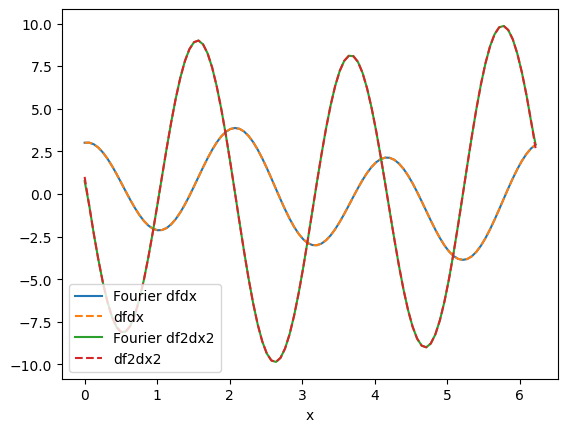

In [39]:
plt.figure()
# 绘制1阶导数（傅里叶计算结果）
plt.plot(x_np, dfdx[0].squeeze().cpu().numpy(), label="Fourier dfdx")
# 绘制1阶导数解析解（3cos(3x)+sin(x)）
plt.plot(x_np, 3 * torch.cos(3 * x) + torch.sin(x), "--", label="dfdx")
# 绘制2阶导数（傅里叶计算结果）
plt.plot(x_np, df2dx2[0].squeeze().cpu().numpy(), label="Fourier df2dx2")
# 绘制2阶导数解析解（-9sin(3x)+cos(x)）
plt.plot(x_np, -9 * torch.sin(3 * x) + torch.cos(x), "--", label="df2dx2")
plt.xlabel("x")
plt.legend()
plt.show()


 ## 绘制exp(-0.8x)+sin(x)的微分结果

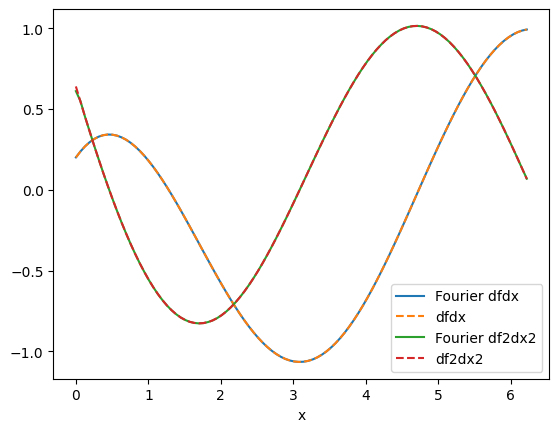

In [40]:
plt.figure()
# 绘制1阶导数（傅里叶计算结果）
plt.plot(x_np, dfdx[1].squeeze().cpu().numpy(), label="Fourier dfdx")
# 绘制1阶导数解析解（-0.8exp(-0.8x)+cos(x)）
plt.plot(x_np, -0.8 * torch.exp(-0.8 * x) + torch.cos(x), "--", label="dfdx")
# 绘制2阶导数（傅里叶计算结果）
plt.plot(x_np, df2dx2[1].squeeze().cpu().numpy(), label="Fourier df2dx2")
# 绘制2阶导数解析解（0.64exp(-0.8x)-sin(x)）
plt.plot(x_np, 0.64 * torch.exp(-0.8 * x) - torch.sin(x), "--", label="df2dx2")
plt.xlabel("x")
plt.legend()
plt.show()


 # 2D傅里叶微分示例

 演示FourierDiff类在2D函数上的应用



 ## 构建2D周期函数示例

 选择f(x,y) = sin(x) * cos(y)，其在[0, 2π] × [0, 2π]域上具有周期性

In [41]:
# 定义x和y方向的周期长度
L_x, L_y = 2 * torch.pi, 2 * torch.pi
# 定义x和y方向的采样点数
nx, ny = 180, 186
# 生成x轴采样点（高精度浮点型）
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
# 生成y轴采样点
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
# 生成2D网格坐标（indexing="ij"表示矩阵索引方式，即先行后列）
X, Y = torch.meshgrid(x, y, indexing="ij")

# 定义2D测试函数：f(x,y) = sin(x) * cos(y)
f_2d = torch.sin(X) * torch.cos(Y)


 ## 对2D信号进行傅里叶微分

 计算一阶偏导数和拉普拉斯算子

In [42]:
# 初始化2D傅里叶微分器：
# - dim=2：指定2维微分
# - L=(L_x, L_y)：指定x和y方向的周期长度
fd2d = FourierDiff(dim=2, L=(L_x, L_y))

# 计算各偏导数：
df_dx = fd2d.dx(f_2d)    # 对x的一阶偏导数 ∂f/∂x
df_dy = fd2d.dy(f_2d)    # 对y的一阶偏导数 ∂f/∂y
laplacian = fd2d.laplacian(f_2d)  # 拉普拉斯算子 ∇²f = ∂²f/∂x² + ∂²f/∂y²

# 计算解析解（理论值）：
df_dx_expected = torch.cos(X) * torch.cos(Y)          # ∂f/∂x 的解析解
df_dy_expected = -torch.sin(X) * torch.sin(Y)         # ∂f/∂y 的解析解
laplacian_expected = -2 * torch.sin(X) * torch.cos(Y) # 拉普拉斯算子的解析解


 ## 绘制2D微分结果

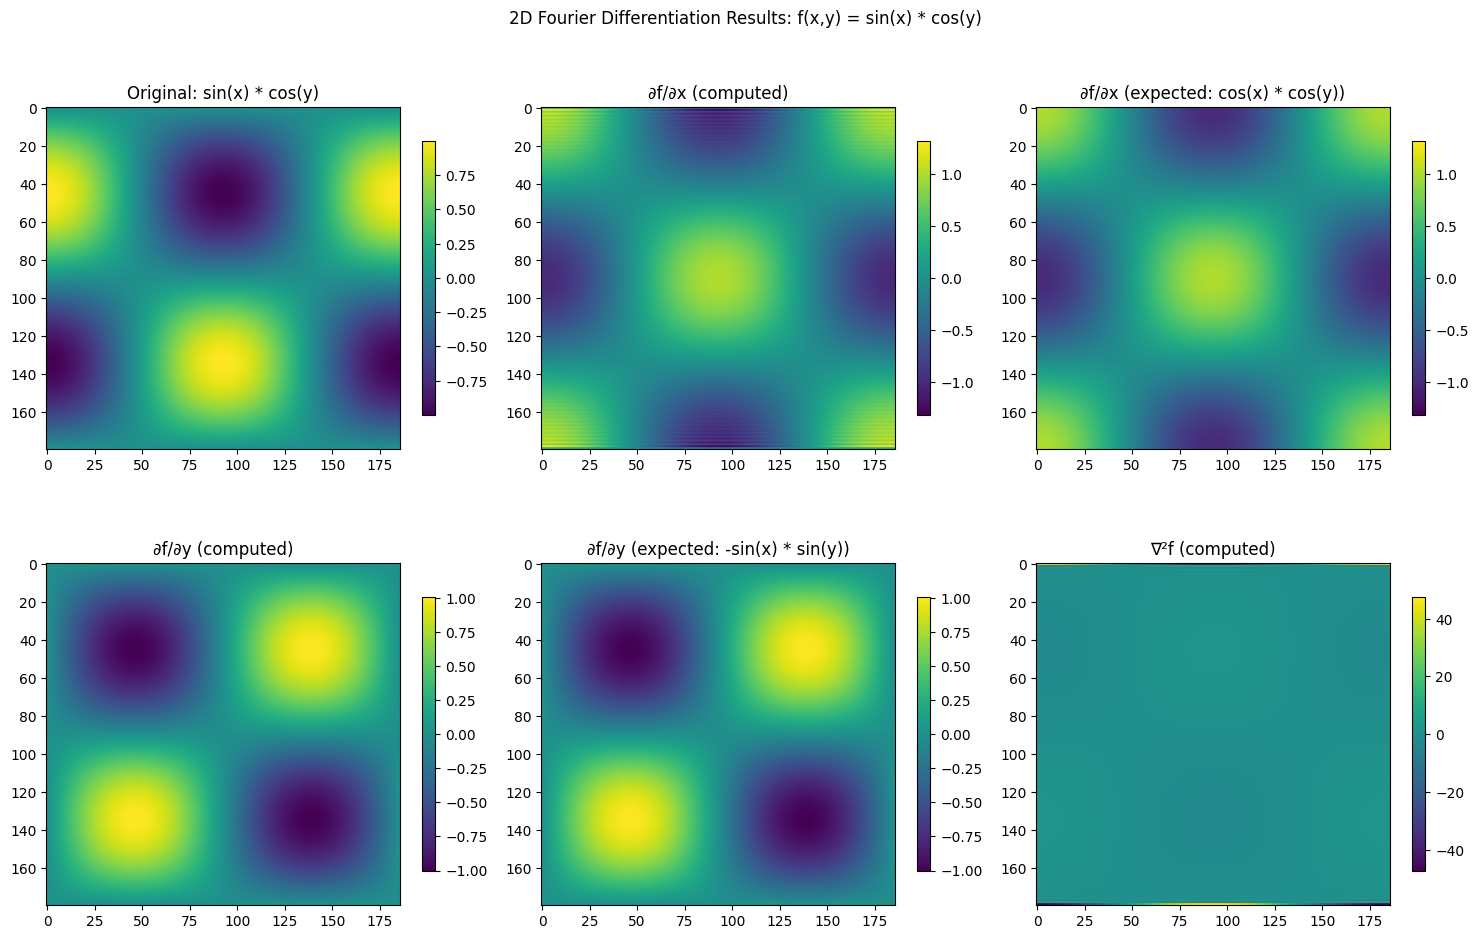

In [43]:
# 创建2行3列的子图布局，设置画布大小
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# 设置总标题
fig.suptitle("2D Fourier Differentiation Results: f(x,y) = sin(x) * cos(y)")

# 为每对导数结果计算统一的颜色条范围（确保可视化对比公平）
df_dx_min = min(df_dx.min().item(), df_dx_expected.min().item())
df_dx_max = max(df_dx.max().item(), df_dx_expected.max().item())
df_dy_min = min(df_dy.min().item(), df_dy_expected.min().item())
df_dy_max = max(df_dy.max().item(), df_dy_expected.max().item())

# 绘制原始函数
im0 = axes[0, 0].imshow(f_2d.cpu().numpy())
axes[0, 0].set_title("Original: sin(x) * cos(y)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.57)

# 绘制∂f/∂x（计算结果）
im1 = axes[0, 1].imshow(df_dx.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 1].set_title("∂f/∂x (computed)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.57)

# 绘制∂f/∂x（解析解）
im2 = axes[0, 2].imshow(df_dx_expected.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 2].set_title("∂f/∂x (expected: cos(x) * cos(y))")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.57)

# 绘制∂f/∂y（计算结果）
im3 = axes[1, 0].imshow(df_dy.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 0].set_title("∂f/∂y (computed)")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.57)

# 绘制∂f/∂y（解析解）
im4 = axes[1, 1].imshow(df_dy_expected.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 1].set_title("∂f/∂y (expected: -sin(x) * sin(y))")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.57)

# 绘制拉普拉斯算子结果
im5 = axes[1, 2].imshow(laplacian.cpu().numpy())
axes[1, 2].set_title("∇²f (computed)")
plt.colorbar(im5, ax=axes[1, 2], shrink=0.57)

# 调整子图间距
plt.tight_layout()
plt.show()


 # 3D傅里叶微分示例

 演示FourierDiff类在3D函数上的应用

 ## 构建3D周期函数示例

 选择f(x,y,z) = sin(x) * cos(y) * sin(z)，其在[0, 2π]³域上具有周期性

In [44]:
# 定义x/y/z方向的周期长度
L_x, L_y, L_z = 2 * torch.pi, 2 * torch.pi, 2 * torch.pi
# 定义x/y/z方向的采样点数
nx, ny, nz = 176, 180, 192
# 生成各轴采样点
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
z = torch.linspace(0, L_z, nz, dtype=torch.float64)
# 生成3D网格坐标
X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")

# 定义3D测试函数：f(x,y,z) = sin(x) * cos(y) * sin(z)
f_3d = torch.sin(X) * torch.cos(Y) * torch.sin(Z)

# 备选示例：直接创建随机3D张量（用于测试通用性）
f_3d_alt = torch.randn(nx, ny, nz, dtype=torch.float64)


 ## 对3D信号进行傅里叶微分

In [45]:
# 初始化3D傅里叶微分器
fd3d = FourierDiff(dim=3, L=(L_x, L_y, L_z))

# 计算各偏导数：
df_dx_3d = fd3d.dx(f_3d)    # ∂f/∂x
df_dy_3d = fd3d.dy(f_3d)    # ∂f/∂y
df_dz_3d = fd3d.dz(f_3d)    # ∂f/∂z
laplacian_3d = fd3d.laplacian(f_3d)  # ∇²f = ∂²f/∂x² + ∂²f/∂y² + ∂²f/∂z²

# 计算解析解：
df_dx_expected_3d = torch.cos(X) * torch.cos(Y) * torch.sin(Z)    # ∂f/∂x 解析解
df_dy_expected_3d = -torch.sin(X) * torch.sin(Y) * torch.sin(Z)   # ∂f/∂y 解析解
df_dz_expected_3d = torch.sin(X) * torch.cos(Y) * torch.cos(Z)    # ∂f/∂z 解析解
laplacian_expected_3d = -3 * torch.sin(X) * torch.cos(Y) * torch.sin(Z)  # 拉普拉斯解析解


 ## 绘制3D结果的切片（z=0平面）

 由于3D数据无法直接可视化，选择z轴中间切片展示

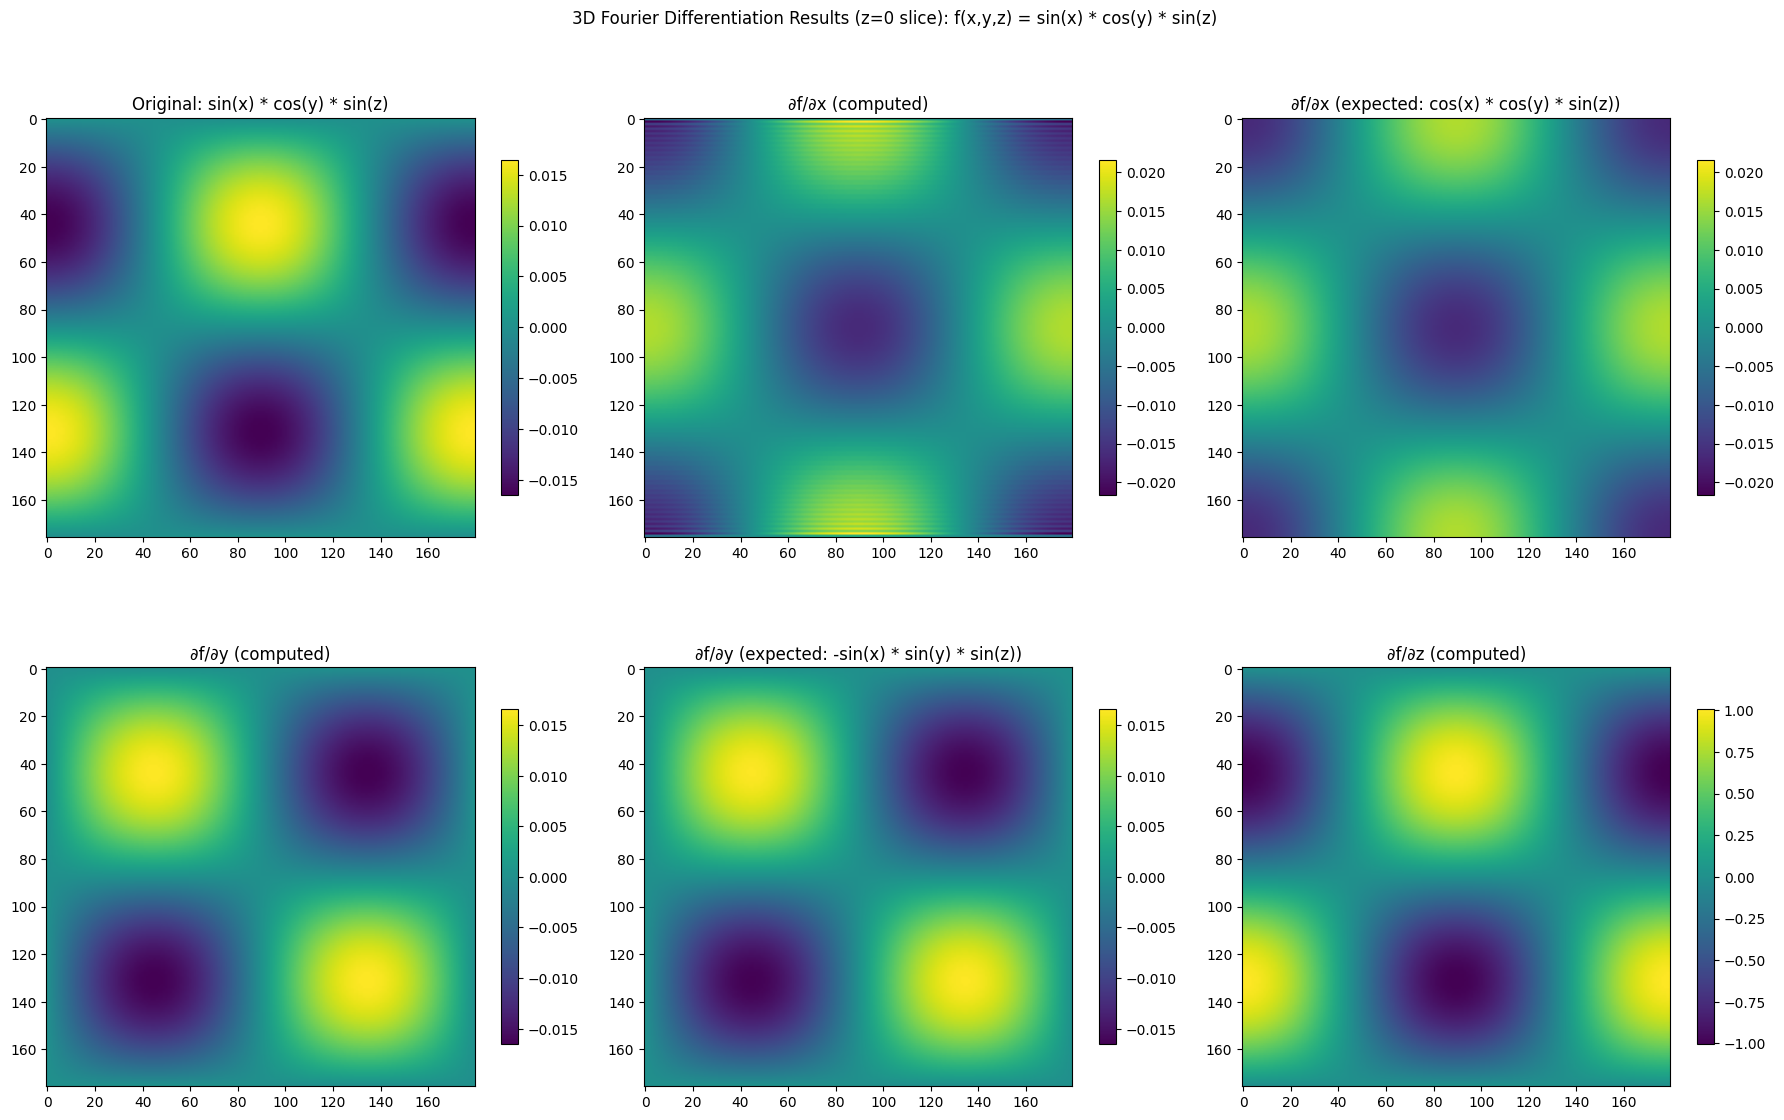

In [46]:
# 选择z轴中间位置作为切片
z_slice_idx = nz // 2
# 创建2行3列的子图布局
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# 设置总标题
fig.suptitle("3D Fourier Differentiation Results (z=0 slice): f(x,y,z) = sin(x) * cos(y) * sin(z)")

# 提取切片数据并计算统一的颜色条范围
df_dx_3d_slice = df_dx_3d[:, :, z_slice_idx]
df_dx_expected_3d_slice = df_dx_expected_3d[:, :, z_slice_idx]
df_dy_3d_slice = df_dy_3d[:, :, z_slice_idx]
df_dy_expected_3d_slice = df_dy_expected_3d[:, :, z_slice_idx]

df_dx_3d_min = min(df_dx_3d_slice.min().item(), df_dx_expected_3d_slice.min().item())
df_dx_3d_max = max(df_dx_3d_slice.max().item(), df_dx_expected_3d_slice.max().item())
df_dy_3d_min = min(df_dy_3d_slice.min().item(), df_dy_expected_3d_slice.min().item())
df_dy_3d_max = max(df_dy_3d_slice.max().item(), df_dy_expected_3d_slice.max().item())

# 绘制原始函数切片
im0 = axes[0, 0].imshow(f_3d[:, :, z_slice_idx].cpu().numpy())
axes[0, 0].set_title("Original: sin(x) * cos(y) * sin(z)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.57)

# 绘制∂f/∂x切片（计算结果）
im1 = axes[0, 1].imshow(df_dx_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 1].set_title("∂f/∂x (computed)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.57)

# 绘制∂f/∂x切片（解析解）
im2 = axes[0, 2].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 2].set_title("∂f/∂x (expected: cos(x) * cos(y) * sin(z))")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.57)

# 绘制∂f/∂y切片（计算结果）
im3 = axes[1, 0].imshow(df_dy_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 0].set_title("∂f/∂y (computed)")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.57)

# 绘制∂f/∂y切片（解析解）
im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title("∂f/∂y (expected: -sin(x) * sin(y) * sin(z))")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.57)

# 绘制∂f/∂z切片（计算结果）
im5 = axes[1, 2].imshow(df_dz_3d[:, :, z_slice_idx].cpu().numpy())
axes[1, 2].set_title("∂f/∂z (computed)")
plt.colorbar(im5, ax=axes[1, 2], shrink=0.57)

plt.tight_layout()
plt.show()